# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP1-DL-YOUR-SURNAME.ipynb') to Ecampus/Moodle before the deadline.


**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).

**Data**
You will have at your disposal the ISIC 2017 dataset (https://challenge.isic-archive.com/data/#2017) already pre-processed, resized and quality checked. It is divided into Training (N=2000), Validation (N=150) and Test (N=600) sets.

**Goal**
The goal of this practical session is to classify images of skin lesions as either benign (nevus or seborrheic_keratosis) or melanoma (binary classification) using machine and deep learning algorithms.

In the first part of the TP, you will manually compute some features relevant to the skin lesion classification (feature engineering) and then classify images using "classical" ML algorithms such as, logistic regression, SVM and Random Forests.

In the second part, you will test the features learnt with Deep Learning algorithms. You will first train from scratch well-known CNN architectures (VGG, ResNet, DenseNet, etc..) and then leverage the representations learnt by these networks on a pre-training from Imagenet (fine-tuning, full-restimation).

Please complete the code where you see **"XXXXXXXXX"** and answer the **Questions**


In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize
from skimage import color
from skimage import measure
from skimage import transform
from skimage.color import rgb2gray
from scipy import ndimage
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import torch
import glob
import cv2
from PIL import Image
from PIL import ImageShow

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import models,transforms
!pip install torchmetrics
import torchmetrics

# torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode


# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


%matplotlib inline

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
except:
  IN_COLAB = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


You can either download the data from my Google Drive or work locally.

In [ ]:
if IN_COLAB:
  print("you are using google colab")
  import gdown
  !mkdir ./data
  gdown.download(id="1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ", output='./data/TrainCropped.zip', quiet=False)
  !unzip -qu "./data/TrainCropped.zip" -d "./data"
  gdown.download(id="1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM", output='./data/TestCropped.zip', quiet=False)
  !unzip -qu "./data/TestCropped.zip" -d "./data"
  gdown.download(id="1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb", output='./data/ValCropped.zip', quiet=False)
  !unzip -qu "./data/ValCropped.zip" -d "./data"
  !rm -rf ./data/TrainCropped.zip
  !rm -rf ./data/TestCropped.zip
  !rm -rf ./data/ValCropped.zip
  path='./data/'
else:
  print('You are NOT using colab')
  # we assume that folders of data are in the same folder as this jupyter notebook
  path='' # if you change this path , you should also change idTRain, idVal and idTest


you are using google colab


Downloading...
From: https://drive.google.com/uc?id=1iH5hkRN0wCgGklUN5df9u2Ue3UXAR4xZ
To: /content/data/TrainCropped.zip
100%|██████████| 31.6M/31.6M [00:00<00:00, 52.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lyRZuV9UST55AEqwSy4mqMmh5yHGI1FM
To: /content/data/TestCropped.zip
100%|██████████| 10.7M/10.7M [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RLJOmqAnHCgiJ7qShQurpxNaRhjjPpJb
To: /content/data/ValCropped.zip
100%|██████████| 2.43M/2.43M [00:00<00:00, 30.3MB/s]


If there is an error (might happen with gdown) please upload the three files manually.
Follow the following instructions:
- go to the folder symbol on the left of your screen
- click on the three vertical dots on the 'data' folder
- upload (importer in french) the three folders
That's it !

In [ ]:
# if IN_COLAB:
#   !unzip -qu "./data/TrainCropped.zip" -d "./data"
#   !unzip -qu "./data/TestCropped.zip" -d "./data"
#   !unzip -qu "./data/ValCropped.zip" -d "./data"
#   !rm -rf ./data/TrainCropped.zip
#   !rm -rf ./data/TestCropped.zip
#   !rm -rf ./data/ValCropped.zip
#   path='./data/'

For the Deep Learning part, we strongly suggest using GPU

In [ ]:
if torch.cuda.is_available():
  print('Is there a GPU card?', torch.cuda.is_available(),'\nNumber of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
  print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))

Is there a GPU card? True 
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.84 GB. Free GPU memory 15.73 GB


Let's load the data.

In [ ]:
pathTrain=glob.glob(path + "TrainCropped/*.jpg")
print(pathTrain)
idTrain=np.copy(pathTrain)
if IN_COLAB:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][20:-4]
else:
    for i in np.arange(len(idTrain)): idTrain[i]=idTrain[i][13:-4]
#print(idTrain)
print('There are', len(idTrain), 'Train images')

['./data/TrainCropped/ISIC_0013526.jpg', './data/TrainCropped/ISIC_0014806.jpg', './data/TrainCropped/ISIC_0000235.jpg', './data/TrainCropped/ISIC_0000331.jpg', './data/TrainCropped/ISIC_0010257.jpg', './data/TrainCropped/ISIC_0000467.jpg', './data/TrainCropped/ISIC_0014308.jpg', './data/TrainCropped/ISIC_0000077.jpg', './data/TrainCropped/ISIC_0013797.jpg', './data/TrainCropped/ISIC_0000013.jpg', './data/TrainCropped/ISIC_0000255.jpg', './data/TrainCropped/ISIC_0014357.jpg', './data/TrainCropped/ISIC_0013721.jpg', './data/TrainCropped/ISIC_0004715.jpg', './data/TrainCropped/ISIC_0009083.jpg', './data/TrainCropped/ISIC_0004168.jpg', './data/TrainCropped/ISIC_0010229.jpg', './data/TrainCropped/ISIC_0000146.jpg', './data/TrainCropped/ISIC_0011343.jpg', './data/TrainCropped/ISIC_0014723.jpg', './data/TrainCropped/ISIC_0013672.jpg', './data/TrainCropped/ISIC_0012788.jpg', './data/TrainCropped/ISIC_0000277.jpg', './data/TrainCropped/ISIC_0014891.jpg', './data/TrainCropped/ISIC_0014576.jpg',

In [ ]:
pathVal=glob.glob(path + "ValCropped/*.jpg")
idVal=np.copy(pathVal)
if IN_COLAB:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][18:-4]
else:
    for i in np.arange(len(idVal)): idVal[i]=idVal[i][11:-4]
#print(idVal)
print('There are', len(idVal) , 'Validation images')

There are 150 Validation images


In [ ]:
pathTest=glob.glob(path + "TestCropped/*.jpg")
idTest=np.copy(pathTest)
if IN_COLAB:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][19:-4]
else:
    for i in np.arange(len(idTest)): idTest[i]=idTest[i][12:-4]
#print(idTest)
print('There are', len(idTest) , 'Test images')

There are 600 Test images


## Loading Metadata and Target values

You have at your disposal also two metadata, the age and the sex. If you want, you can use them as features in the classification but be careful ! There are missing values

We also load the target values (0 for benign and 1 for melanoma)

In [ ]:
Metatrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Data_metadata.csv')
print(Metatrain.head(10))
Groundtrain = pd.read_csv('./data/TrainCropped/ISIC-2017_Training_Part3_GroundTruth.csv')

       image_id age_approximate     sex
0  ISIC_0000000              55  female
1  ISIC_0000001              30  female
2  ISIC_0000002              60  female
3  ISIC_0000003              30    male
4  ISIC_0000004              80    male
5  ISIC_0000006              25  female
6  ISIC_0000007              25  female
7  ISIC_0000008              30  female
8  ISIC_0000009              30  female
9  ISIC_0000010              35  female


In [ ]:
Metatrain.shape,  Groundtrain.shape

((2000, 3), (2000, 3))

In [ ]:
Groundtrain.head()

image_id  melanoma  seborrheic_keratosis
0  ISIC_0000000       0.0                   0.0
1  ISIC_0000001       0.0                   0.0
2  ISIC_0000002       1.0                   0.0
3  ISIC_0000003       0.0                   0.0
4  ISIC_0000004       1.0                   0.0

In [ ]:
Ytrain=np.zeros(len(idTrain))
for i in range(len(idTrain)):
  name=idTrain[i]
  index=Groundtrain["image_id"].str.find(name)
  max_index = index.argmax()
  Ytrain[i]=int(Groundtrain["melanoma"][max_index])

In [ ]:
Ytrain.shape, Ytrain

((2000,), array([0., 0., 0., ..., 0., 1., 0.]))

In [ ]:
Metaval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Data_metadata.csv')
Groundval = pd.read_csv('./data/ValCropped/ISIC-2017_Validation_Part3_GroundTruth.csv')

In [ ]:
Yval=np.zeros(len(idVal))
for i in range(len(idVal)):
  name=idVal[i]
  index=Groundval["image_id"].str.find(name)
  max_index = index.argmax()
  Yval[i]=int(Groundval["melanoma"][max_index])

In [ ]:
Metatest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Data_metadata.csv')
Groundtest = pd.read_csv('./data/TestCropped/ISIC-2017_Test_v2_Part3_GroundTruth.csv')

In [ ]:
Ytest=np.zeros(len(idTest))
for i in range(len(idTest)):
  name=idTest[i]
  index=Groundtest["image_id"].str.find(name)
  max_index = index.argmax()
  Ytest[i]=int(Groundtest["melanoma"][max_index])

##Deep Learning
In this section, you will try simple Deep Learning strategies:
- Fine-tuning the last layer of a network already trained on Image-Net
- Re-training completely a network already trained on Image-Net
- Re-training from scratch a network that has already shown good performances on other data-sets (architecture transfer or inductive bias transfer)

You will have to use at least three different networks (e.g., ResNet, VGG, DenseNet)

**Please compute the full time (reading papers/tutorials, coding, computational time) you spend on this part. It will be asked at the end of the practical session**

Pytorch also offers two nice primitives for storing and working with datasets:

*   **Dataset** stores the images, labels and segmentation masks
*   **DataLoader** wraps an iterable around the elements of the Dataset

This is very practical since we can easily resize the images to the same size (important for DL) and multiply image and segmentation masks. Here, you have an exemple.

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, pathlist, targets, size=(224,224)):
        self.image_paths = pathlist
        self.mask_paths = [ p[:-4]+'seg.png' for p in pathlist ]
        self.targets = torch.LongTensor(targets)
        self.size=size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        y = self.targets[idx]

        x = Image.open(img_path).resize(self.size, Image.BILINEAR) # all images are resized to (224,224)
        s = Image.open(mask_path).resize(self.size, Image.NEAREST) # all segmentation masks are resized to (224,224)

        # Multiply image and segmentation mask
        blank = x.point(lambda _: 0)
        c = Image.composite(x, blank, s)

        # Send to tensor
        x = TF.to_tensor(x)
        c = TF.to_tensor(c)

        # Normalize according to ImageNet statistics
        x = TF.normalize(x,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        c = TF.normalize(c,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return x, c, y


Another reason why DataSets and DataLoaders are practical is that we can automatically apply data augmentation strategies. For instance, if we want to automatically apply (the same) data augmentations to both images and segmentations, we can use:

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class ISICDatasetWithAug(Dataset):
    def __init__(self, pathlist, targets, size=(224,224)):
        self.image_paths = pathlist
        self.mask_paths = [ p[:-4]+'seg.png' for p in pathlist ]
        self.targets = torch.LongTensor(targets)
        self.size=size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        y = self.targets[idx]

        x = Image.open(img_path).resize(self.size, Image.BILINEAR) # all images are resized to (224,224)
        s = Image.open(mask_path).resize(self.size, Image.NEAREST) # all segmentation masks are resized to (224,224)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(x, output_size=(128, 128))
        x = TF.crop(x, i, j, h, w)
        s = TF.crop(s, i, j, h, w)

        # Random horizontal flipping
        if np.random.random() > 0.5:
          x = TF.hflip(x)
          s = TF.hflip(s)

        # Random vertical flipping
        if np.random.random() > 0.5:
            x = TF.vflip(x)
            s = TF.vflip(s)

        # Random rotation
        angle=np.random.randint(-90, 90)
        x=TF.rotate(x, angle, InterpolationMode.BILINEAR)
        s=TF.rotate(s,angle, InterpolationMode.NEAREST)

        # Multiply image and segmentation mask
        blank = x.point(lambda _: 0)
        c = Image.composite(x, blank, s)

        # Send to tensor
        x = TF.to_tensor(x)
        c = TF.to_tensor(c)

        # Normalize according to ImageNet statistics
        x = TF.normalize(x,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        c = TF.normalize(c,(0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        return x, c, y




You have probably noticed that there are three outputs.

**Question**: Explain what they are and which data augmentations we are computing.

The three outputs being returned by the ISICDatasetWithAug class are the original input image (x) with augmentation, the augmented image with its segmentation mask applied (c), and the target label (y). Augmentations applied to the input image involve resizing, random cropping (50% chance), horizontal (50% chance) and vertical flipping (50% chance), and random rotation. The segmentation mask undergoes the same augmentations, and both the original image and its mask are multiplied to create the augmented image (c). The purpose of data augmentation is to enhance the model's robustness by introducing variations in spatial transformations, enabling it to better generalize to different orientations and scales, thus preventing overfitting.

Then, we can load the data

In [ ]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
if torch.cuda.is_available():
    torch.cuda.manual_seed(10)
    torch.backends.cudnn.deterministic = True

# Ensure that you are using GPU
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

batch_size = 256 # adapted to the Google Colab GPU
num_epochs = 5 # to be modified
learning_rate = 0.05 # to be modified

train_dataset = ISICDataset(pathTrain, Ytrain)
val_dataset=ISICDataset(pathVal, Yval)
test_dataset=ISICDataset(pathTest, Ytest)

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

Device: cuda:0


In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2000, 150, 600)

### 1.1 Last layer fine-tuning of pre-trained ResNet18

The first part will be about fine-tuning the last layer of a network already pre-trained on Image-Net. Here it is the code:

In [ ]:
num_classes = 1 # since we use the BCEWithLogitsLoss, we only have one output (if you were using CrossEntropy Loss, num_classes would be 2)

# Load a pre-trained ResNet-18 model
resnet18 = models.resnet18(weights = 'IMAGENET1K_V1')
# Freeze all parameters of the model
for param in resnet18.parameters():
    param.requires_grad = False
# Change last layer, the fully connected layer (classifier)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.4MB/s]


Then, we can train this last layer on the training data. Find the best model in the validation set and evaluate the generalization performance on the test set. If you look for the best hyper-parameter, you should also use the validation set.

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [ ]:
pd.Series(Ytrain).value_counts()

0.0    1626
1.0     374
dtype: int64

In [ ]:
len(train_dataset) / sum(Ytrain)

5.347593582887701

Since the dataset is highly imblanaced, i.e around 4.34 positive samples (1) for each negative sample(0), the pos_weight parameter in the BCEWithLogitsLoss is used. It is set to the inverse of the ratio between the total number of training samples (N_Train) and the sum of positive labels (sum(Ytrain)) because we are trying to assign a weight to the positive class that is proportional to its underrepresentation in the dataset. We are essentially telling the loss function to pay more attention to the positive class during training (penalize errors with the positive class more). This helps the model to better focus on learning patterns associated with the minority class.

In [ ]:
from tqdm.notebook import tqdm

model = resnet18.float().cuda() # use float32 to save a bit of memory

# pos_weight is N_Train/sum(Ytrain) -> why in your opinion ?
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([5.347593582887701]).cuda())
auc = torchmetrics.AUROC(task='binary',num_classes=2, average = 'macro').cuda()
accuracy = torchmetrics.Accuracy(task='binary',num_classes = 2, average='micro').cuda()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)
Tensor = torch.cuda.FloatTensor # use float32 to save a bit of memory

In [ ]:
# Training
import time

def fit(model, optimizer, scheduler = None, input_img_type = "masked_image"):
  start_time = time.time()
  for epoch in tqdm(range(num_epochs)):
      model.train()
      train_loss = 0.0
      for images, composite, labels in tqdm(train_loader):
          optimizer.zero_grad()

          if input_img_type == "full_image":
            outputs = model(images.float().cuda())
          else:
            outputs = model(composite.float().cuda())

          loss = criterion(outputs.squeeze(), labels.float().cuda())
          loss.backward()
          optimizer.step()
          if scheduler:
            scheduler.step()

          if input_img_type == "full_image":
            train_loss += loss.detach().cpu().numpy() * images.size(0)
          else:
            train_loss += loss.detach().cpu().numpy() * composite.size(0)

      train_loss = train_loss / len(train_dataset)

      all_preds=[]
      all_labels=[]
      # Validation
      model.eval()
      # reset auc and accuracy to prevent accumulation
      auc.reset()
      accuracy.reset()
      val_loss = 0.0
      with torch.no_grad():
          for images, composite, labels in tqdm(val_loader):

              if input_img_type == "full_image":
                outputs = model(images.float().cuda())
              else:
                outputs = model(composite.float().cuda())

              loss = criterion(outputs.squeeze(), labels.float().cuda())

              if input_img_type == "full_image":
                val_loss += loss.detach().cpu().numpy() * images.size(0)
              else:
                val_loss += loss.detach().cpu().numpy() * composite.size(0)

              preds=torch.sigmoid(outputs).squeeze()
              auc.update(preds, labels.cuda())
              accuracy.update(preds, labels.cuda())
      val_loss = val_loss / len(val_dataset)
      val_auc = auc.compute()
      val_acc = accuracy.compute()
      print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Val AUC: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss, val_auc, val_acc))
  end_time = time.time()
  print("Time taken: {:.2f} seconds".format(end_time - start_time))
  return model, train_loss, val_loss, val_auc, val_acc

In [ ]:
### Testing
def test(model):
  auc.reset()
  accuracy.reset()
  start_time = time.time()
  model.eval()
  test_loss=0
  with torch.no_grad():
      for images, composite, labels in tqdm(test_loader):
          outputs = model(images.float().cuda())
          loss = criterion(outputs.squeeze(), labels.float().cuda())
          test_loss += loss.item()
          preds=torch.sigmoid(outputs).squeeze()
          auc.update(preds, labels.cuda())
          accuracy.update(preds, labels.cuda())
  test_loss = test_loss / len(test_dataset)
  test_auc = auc.compute()
  test_acc = accuracy.compute()
  end_time = time.time()
  print('\nTest Loss: {:.4f}, Test AUC: {:.4f}, Test Acc: {:.4f}'.format(test_loss, test_auc, test_acc))
  print("Time taken: {:.2f} seconds".format(end_time - start_time))
  return test_loss, test_auc, test_acc

In [ ]:
import gc

def clear_gpu_memory(model, optimizer):
  torch.cuda.empty_cache()
  del model
  del optimizer
  gc.collect()
  print("deleted model, memory cleared")

In [ ]:
#Training with masked images
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 11.3801, Val Loss: 3.7059, Val AUC: 0.6922, Val Acc: 0.8000


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 4.0798, Val Loss: 1.6792, Val AUC: 0.7522, Val Acc: 0.8133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 2.4043, Val Loss: 1.4234, Val AUC: 0.7911, Val Acc: 0.8133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 1.6671, Val Loss: 1.6053, Val AUC: 0.7978, Val Acc: 0.8667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 1.4966, Val Loss: 2.3485, Val AUC: 0.8094, Val Acc: 0.8400
Time taken: 66.18 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/3 [00:00<?, ?it/s]


Test Loss: 0.0193, Test AUC: 0.7196, Test Acc: 0.8033
Time taken: 3.14 seconds


In [ ]:
del resnet18
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.resnet18(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 1.4282, Val Loss: 1.1851, Val AUC: 0.6844, Val Acc: 0.6133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 1.4799, Val Loss: 1.8042, Val AUC: 0.7383, Val Acc: 0.8067


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 1.0876, Val Loss: 1.0128, Val AUC: 0.8017, Val Acc: 0.7667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.9454, Val Loss: 1.0307, Val AUC: 0.8042, Val Acc: 0.7733


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.8962, Val Loss: 1.0090, Val AUC: 0.8067, Val Acc: 0.7400
Time taken: 55.23 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/3 [00:00<?, ?it/s]


Test Loss: 0.0053, Test AUC: 0.7746, Test Acc: 0.6367
Time taken: 3.67 seconds


Now, it's time to retrain the entire network (previously pre-trained on Imagenet)


### 1.2 Full fine-tuning of pre-trained ResNet18

In [ ]:
num_epochs = 10 # to be modified
learning_rate = 0.0001 # to be modified

In [ ]:
model = models.resnet18(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = True

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.3273, Val Loss: 1.2978, Val AUC: 0.7103, Val Acc: 0.7867


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 1.0767, Val Loss: 1.0522, Val AUC: 0.8147, Val Acc: 0.8067


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.7733, Val Loss: 0.9773, Val AUC: 0.8353, Val Acc: 0.8333


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.5069, Val Loss: 0.9403, Val AUC: 0.8533, Val Acc: 0.8267


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.2979, Val Loss: 0.9415, Val AUC: 0.8453, Val Acc: 0.8467


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.1526, Val Loss: 0.9622, Val AUC: 0.8342, Val Acc: 0.8267


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.0906, Val Loss: 1.0222, Val AUC: 0.8375, Val Acc: 0.8600


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.0666, Val Loss: 1.0806, Val AUC: 0.8450, Val Acc: 0.8600


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.0577, Val Loss: 1.1426, Val AUC: 0.8450, Val Acc: 0.8600


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.0547, Val Loss: 1.1805, Val AUC: 0.8439, Val Acc: 0.8533
Time taken: 123.87 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/3 [00:00<?, ?it/s]


Test Loss: 0.0099, Test AUC: 0.7265, Test Acc: 0.8150
Time taken: 3.09 seconds


In [ ]:
clear_gpu_memory(model, optimizer) #In order to re-initialize model, and clear GPU memory, and not train on top of previous training

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.resnet18(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = True

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.3000, Val Loss: 1.2657, Val AUC: 0.6008, Val Acc: 0.2533


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 1.1009, Val Loss: 1.0432, Val AUC: 0.7811, Val Acc: 0.5867


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.7961, Val Loss: 0.9321, Val AUC: 0.8386, Val Acc: 0.6467


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.4612, Val Loss: 0.8681, Val AUC: 0.8636, Val Acc: 0.7400


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.2207, Val Loss: 0.8713, Val AUC: 0.8672, Val Acc: 0.7867


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.1028, Val Loss: 0.8579, Val AUC: 0.8797, Val Acc: 0.8000


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.0619, Val Loss: 0.9150, Val AUC: 0.8781, Val Acc: 0.8600


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.0428, Val Loss: 1.0351, Val AUC: 0.8769, Val Acc: 0.8667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.0379, Val Loss: 1.1131, Val AUC: 0.8756, Val Acc: 0.8667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.0366, Val Loss: 1.1472, Val AUC: 0.8764, Val Acc: 0.8600
Time taken: 125.07 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/3 [00:00<?, ?it/s]


Test Loss: 0.0062, Test AUC: 0.8228, Test Acc: 0.8200
Time taken: 3.86 seconds


And eventually train from scratch the network, namely the weights should be randomly initiliazed.

### 1.3 Full training of ResNet18 from scratch

In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
num_epochs = 15 # to be modified
learning_rate = 3e-3 # to be modified

batch_size = 128

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

In [ ]:
model = models.resnet18(weights = None)

for param in model.parameters():
    param.requires_grad = True

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/15], Train Loss: 1.2525, Val Loss: 1.7044, Val AUC: 0.5139, Val Acc: 0.8000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/15], Train Loss: 1.2487, Val Loss: 3.8165, Val AUC: 0.4714, Val Acc: 0.2000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/15], Train Loss: 1.2497, Val Loss: 5.6098, Val AUC: 0.4236, Val Acc: 0.2000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/15], Train Loss: 1.2460, Val Loss: 1.3623, Val AUC: 0.5831, Val Acc: 0.6400


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/15], Train Loss: 1.1866, Val Loss: 1.9184, Val AUC: 0.5281, Val Acc: 0.7667


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/15], Train Loss: 1.1578, Val Loss: 1.2659, Val AUC: 0.6653, Val Acc: 0.2667


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/15], Train Loss: 1.1635, Val Loss: 2.1220, Val AUC: 0.5922, Val Acc: 0.7533


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/15], Train Loss: 1.1272, Val Loss: 1.5118, Val AUC: 0.5406, Val Acc: 0.6800


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/15], Train Loss: 1.0349, Val Loss: 1.5976, Val AUC: 0.4453, Val Acc: 0.4467


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/15], Train Loss: 0.9328, Val Loss: 1.4923, Val AUC: 0.5533, Val Acc: 0.6667


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/15], Train Loss: 0.8395, Val Loss: 1.9644, Val AUC: 0.6083, Val Acc: 0.7400


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/15], Train Loss: 0.5948, Val Loss: 2.1069, Val AUC: 0.5961, Val Acc: 0.7467


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/15], Train Loss: 0.3586, Val Loss: 2.2572, Val AUC: 0.5806, Val Acc: 0.6867


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/15], Train Loss: 0.2194, Val Loss: 2.5687, Val AUC: 0.5581, Val Acc: 0.7000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/15], Train Loss: 0.1633, Val Loss: 2.7022, Val AUC: 0.5647, Val Acc: 0.7067
Time taken: 182.03 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/5 [00:00<?, ?it/s]


Test Loss: 0.0524, Test AUC: 0.5460, Test Acc: 0.8117
Time taken: 3.97 seconds


In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.resnet18(weights = None)

for param in model.parameters():
    param.requires_grad = True

model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/15], Train Loss: 1.3309, Val Loss: 1.2530, Val AUC: 0.5847, Val Acc: 0.4400


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/15], Train Loss: 1.3060, Val Loss: 2.8082, Val AUC: 0.6367, Val Acc: 0.2133


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/15], Train Loss: 1.3199, Val Loss: 2.5006, Val AUC: 0.4331, Val Acc: 0.6867


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/15], Train Loss: 1.2398, Val Loss: 1.4432, Val AUC: 0.3906, Val Acc: 0.3600


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/15], Train Loss: 1.2354, Val Loss: 1.3587, Val AUC: 0.5417, Val Acc: 0.2000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/15], Train Loss: 1.2287, Val Loss: 1.2597, Val AUC: 0.6419, Val Acc: 0.2200


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/15], Train Loss: 1.2160, Val Loss: 1.2172, Val AUC: 0.7064, Val Acc: 0.2467


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/15], Train Loss: 1.1875, Val Loss: 1.3321, Val AUC: 0.5947, Val Acc: 0.3067


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/15], Train Loss: 1.1611, Val Loss: 1.4401, Val AUC: 0.6322, Val Acc: 0.3067


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/15], Train Loss: 1.1434, Val Loss: 1.2759, Val AUC: 0.6025, Val Acc: 0.3933


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/15], Train Loss: 1.1179, Val Loss: 1.3123, Val AUC: 0.6089, Val Acc: 0.4400


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/15], Train Loss: 1.0882, Val Loss: 1.2809, Val AUC: 0.6517, Val Acc: 0.6600


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/15], Train Loss: 1.0404, Val Loss: 1.3091, Val AUC: 0.6358, Val Acc: 0.5133


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/15], Train Loss: 1.0122, Val Loss: 1.3231, Val AUC: 0.6397, Val Acc: 0.5333


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/15], Train Loss: 0.9900, Val Loss: 1.3152, Val AUC: 0.6414, Val Acc: 0.6067
Time taken: 179.79 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/5 [00:00<?, ?it/s]


Test Loss: 0.0110, Test AUC: 0.6094, Test Acc: 0.5100
Time taken: 4.16 seconds


In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.2 GB
Cached:    3.9 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


**Question**: Train at least 3 different networks using the three strategies. Use the validation set to compare the performance of the three models and evaluate the best-performing one on the test set. Which is the best strategy ? Are you satisfied ?

Apart from the Resnet18, I chose the MobileNetV2 and EfficientNetB1 networks for further experimentation on this dataset. Hyperparameter tuning based on the validation set and then checking the performance on the test set is the conventional way to do it.
With more time and more computing resources, a K-Fold evaluation strategy could be employed, which gives a better estimate of the optimal hyperparameters.

### 2.1 Last-layer fine-tuning of pre-trained MobileNetV2

In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
num_epochs = 7 # to be modified
learning_rate = 0.003 # to be modified

batch_size = 128

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

In [ ]:
model = models.mobilenet_v2(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s] 


In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/7], Train Loss: 1.2438, Val Loss: 1.1954, Val AUC: 0.7114, Val Acc: 0.4133


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/7], Train Loss: 1.1453, Val Loss: 1.0731, Val AUC: 0.8053, Val Acc: 0.5067


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/7], Train Loss: 1.0436, Val Loss: 1.0159, Val AUC: 0.8153, Val Acc: 0.6000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/7], Train Loss: 0.9830, Val Loss: 0.9896, Val AUC: 0.8236, Val Acc: 0.6600


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/7], Train Loss: 0.9589, Val Loss: 1.0316, Val AUC: 0.8164, Val Acc: 0.7400


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/7], Train Loss: 0.9435, Val Loss: 0.9988, Val AUC: 0.8197, Val Acc: 0.7133


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/7], Train Loss: 0.9290, Val Loss: 0.9967, Val AUC: 0.8194, Val Acc: 0.7133
Time taken: 75.11 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/5 [00:00<?, ?it/s]


Test Loss: 0.0132, Test AUC: 0.6220, Test Acc: 0.7167
Time taken: 2.97 seconds


In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.mobilenet_v2(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/7], Train Loss: 1.2418, Val Loss: 1.1856, Val AUC: 0.7261, Val Acc: 0.3800


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/7], Train Loss: 1.0985, Val Loss: 1.0888, Val AUC: 0.8003, Val Acc: 0.8000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/7], Train Loss: 1.0082, Val Loss: 1.0141, Val AUC: 0.8058, Val Acc: 0.7267


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/7], Train Loss: 0.9231, Val Loss: 0.9654, Val AUC: 0.8222, Val Acc: 0.6933


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/7], Train Loss: 0.8929, Val Loss: 0.9536, Val AUC: 0.8236, Val Acc: 0.7267


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/7], Train Loss: 0.8801, Val Loss: 1.0223, Val AUC: 0.8233, Val Acc: 0.7867


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/7], Train Loss: 0.8642, Val Loss: 0.9743, Val AUC: 0.8292, Val Acc: 0.7733
Time taken: 78.06 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/5 [00:00<?, ?it/s]


Test Loss: 0.0081, Test AUC: 0.8087, Test Acc: 0.6517
Time taken: 2.97 seconds


### 2.2 Full fine-tuning of pre-trained MobileNetV2

In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
num_epochs = 10 # to be modified
learning_rate = 3e-3 # to be modified

In [ ]:
model = models.mobilenet_v2(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.0993, Val Loss: 1.8013, Val AUC: 0.7883, Val Acc: 0.8000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.9843, Val Loss: 1.5159, Val AUC: 0.5564, Val Acc: 0.5800


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.0363, Val Loss: 1.6794, Val AUC: 0.7861, Val Acc: 0.4400


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.9531, Val Loss: 1.6539, Val AUC: 0.7425, Val Acc: 0.8067


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.8225, Val Loss: 1.4501, Val AUC: 0.7525, Val Acc: 0.4200


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.5634, Val Loss: 1.4180, Val AUC: 0.7461, Val Acc: 0.6867


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.3599, Val Loss: 1.8830, Val AUC: 0.8058, Val Acc: 0.7867


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.2466, Val Loss: 1.7154, Val AUC: 0.8414, Val Acc: 0.8267


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.1045, Val Loss: 1.9358, Val AUC: 0.8236, Val Acc: 0.8400


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.0757, Val Loss: 1.9890, Val AUC: 0.8264, Val Acc: 0.8333
Time taken: 127.42 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/5 [00:00<?, ?it/s]


Test Loss: 0.0245, Test AUC: 0.7334, Test Acc: 0.8150
Time taken: 4.10 seconds


In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.mobilenet_v2(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.1563, Val Loss: 1.1969, Val AUC: 0.7497, Val Acc: 0.7000


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.9368, Val Loss: 2.9680, Val AUC: 0.7281, Val Acc: 0.8133


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.0132, Val Loss: 2.5333, Val AUC: 0.6314, Val Acc: 0.7333


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 0.8387, Val Loss: 2.7860, Val AUC: 0.6658, Val Acc: 0.7600


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 0.7407, Val Loss: 1.1350, Val AUC: 0.8228, Val Acc: 0.7533


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.4491, Val Loss: 1.7742, Val AUC: 0.8464, Val Acc: 0.8333


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.2780, Val Loss: 1.9686, Val AUC: 0.8197, Val Acc: 0.7933


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.1735, Val Loss: 1.4687, Val AUC: 0.8356, Val Acc: 0.8067


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.0729, Val Loss: 1.9757, Val AUC: 0.8089, Val Acc: 0.8333


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.0446, Val Loss: 1.8826, Val AUC: 0.8172, Val Acc: 0.8467
Time taken: 126.90 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/5 [00:00<?, ?it/s]


Test Loss: 0.0129, Test AUC: 0.8245, Test Acc: 0.7983
Time taken: 3.02 seconds


### 2.3 Full training MobileNetV2 from scratch



In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
num_epochs = 15 # to be modified
learning_rate = 5e-3 # to be modified

In [ ]:
model = models.mobilenet_v2(weights = None)

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/15], Train Loss: 1.2506, Val Loss: 1.2960, Val AUC: 0.5507, Val Acc: 0.8000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/15], Train Loss: 1.2595, Val Loss: 2.2344, Val AUC: 0.4561, Val Acc: 0.8000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/15], Train Loss: 1.3371, Val Loss: 1.4328, Val AUC: 0.5122, Val Acc: 0.4067


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/15], Train Loss: 1.2710, Val Loss: 1.8827, Val AUC: 0.5203, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/15], Train Loss: 1.3190, Val Loss: 1.3783, Val AUC: 0.4914, Val Acc: 0.3733


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/15], Train Loss: 1.2363, Val Loss: 1.3228, Val AUC: 0.5525, Val Acc: 0.2400


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/15], Train Loss: 1.2089, Val Loss: 1.5506, Val AUC: 0.4406, Val Acc: 0.4533


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8/15], Train Loss: 1.1992, Val Loss: 1.3372, Val AUC: 0.5494, Val Acc: 0.3200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9/15], Train Loss: 1.1632, Val Loss: 1.3289, Val AUC: 0.5778, Val Acc: 0.3533


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/15], Train Loss: 1.0408, Val Loss: 1.3856, Val AUC: 0.5608, Val Acc: 0.5933


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [11/15], Train Loss: 0.9744, Val Loss: 1.6985, Val AUC: 0.4978, Val Acc: 0.4333


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [12/15], Train Loss: 0.6660, Val Loss: 2.3336, Val AUC: 0.5778, Val Acc: 0.6533


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [13/15], Train Loss: 0.3519, Val Loss: 2.2781, Val AUC: 0.5767, Val Acc: 0.6333


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [14/15], Train Loss: 0.1638, Val Loss: 2.8793, Val AUC: 0.5792, Val Acc: 0.7200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [15/15], Train Loss: 0.1335, Val Loss: 2.8482, Val AUC: 0.5886, Val Acc: 0.7200
Time taken: 217.93 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0620, Test AUC: 0.4759, Test Acc: 0.7817
Time taken: 4.98 seconds


In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.mobilenet_v2(weights = None)

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/15], Train Loss: 1.2508, Val Loss: 1.6077, Val AUC: 0.4378, Val Acc: 0.8000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/15], Train Loss: 1.2833, Val Loss: 1.3228, Val AUC: 0.4128, Val Acc: 0.4200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/15], Train Loss: 1.3112, Val Loss: 1.4024, Val AUC: 0.4244, Val Acc: 0.3267


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/15], Train Loss: 1.2903, Val Loss: 1.7467, Val AUC: 0.5758, Val Acc: 0.4600


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/15], Train Loss: 1.3409, Val Loss: 1.3689, Val AUC: 0.7028, Val Acc: 0.8200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/15], Train Loss: 1.2636, Val Loss: 1.3262, Val AUC: 0.5200, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/15], Train Loss: 1.2322, Val Loss: 1.2439, Val AUC: 0.6517, Val Acc: 0.5333


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8/15], Train Loss: 1.2315, Val Loss: 1.2380, Val AUC: 0.6708, Val Acc: 0.4200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9/15], Train Loss: 1.2311, Val Loss: 1.2165, Val AUC: 0.6444, Val Acc: 0.5200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/15], Train Loss: 1.2161, Val Loss: 1.3972, Val AUC: 0.5569, Val Acc: 0.5133


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [11/15], Train Loss: 1.1876, Val Loss: 1.2196, Val AUC: 0.6472, Val Acc: 0.6000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [12/15], Train Loss: 1.1286, Val Loss: 1.2704, Val AUC: 0.6192, Val Acc: 0.5667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [13/15], Train Loss: 1.0487, Val Loss: 1.2279, Val AUC: 0.6569, Val Acc: 0.4800


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [14/15], Train Loss: 1.0084, Val Loss: 1.3389, Val AUC: 0.6111, Val Acc: 0.5067


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [15/15], Train Loss: 0.9367, Val Loss: 1.2919, Val AUC: 0.6297, Val Acc: 0.5400
Time taken: 237.89 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0218, Test AUC: 0.6666, Test Acc: 0.5417
Time taken: 2.97 seconds


### 3.1 Last-layer finetuning of EfficientNetB1

In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
num_epochs = 10 # to be modified
learning_rate = 3e-4 # to be modified
batch_size = 64

train_loader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, num_workers=1, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

In [ ]:
model = models.efficientnet_b1(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 132MB/s]


In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.2511, Val Loss: 1.2796, Val AUC: 0.5258, Val Acc: 0.3533


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 1.2271, Val Loss: 1.2499, Val AUC: 0.5978, Val Acc: 0.3200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.2011, Val Loss: 1.2273, Val AUC: 0.6533, Val Acc: 0.3867


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.1664, Val Loss: 1.2090, Val AUC: 0.6808, Val Acc: 0.4400


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.1421, Val Loss: 1.1982, Val AUC: 0.6903, Val Acc: 0.5000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 1.1168, Val Loss: 1.1915, Val AUC: 0.7014, Val Acc: 0.5667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 1.1134, Val Loss: 1.1819, Val AUC: 0.7114, Val Acc: 0.5933


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 1.1012, Val Loss: 1.1732, Val AUC: 0.7217, Val Acc: 0.5800


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 1.0933, Val Loss: 1.1691, Val AUC: 0.7267, Val Acc: 0.5733


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 1.1038, Val Loss: 1.1738, Val AUC: 0.7172, Val Acc: 0.5800
Time taken: 113.61 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0208, Test AUC: 0.6529, Test Acc: 0.5717
Time taken: 3.63 seconds


In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.efficientnet_b1(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.2626, Val Loss: 1.3244, Val AUC: 0.4100, Val Acc: 0.4267


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 1.2402, Val Loss: 1.2873, Val AUC: 0.5119, Val Acc: 0.3600


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.2044, Val Loss: 1.2436, Val AUC: 0.6494, Val Acc: 0.4467


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.1792, Val Loss: 1.1902, Val AUC: 0.7428, Val Acc: 0.5333


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.1477, Val Loss: 1.1594, Val AUC: 0.7900, Val Acc: 0.6467


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 1.1269, Val Loss: 1.1430, Val AUC: 0.8031, Val Acc: 0.6600


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 1.1176, Val Loss: 1.1255, Val AUC: 0.8161, Val Acc: 0.6600


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 1.0998, Val Loss: 1.1206, Val AUC: 0.8081, Val Acc: 0.6667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 1.0937, Val Loss: 1.1155, Val AUC: 0.8139, Val Acc: 0.6800


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 1.0973, Val Loss: 1.1147, Val AUC: 0.8211, Val Acc: 0.7067
Time taken: 120.98 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0191, Test AUC: 0.7558, Test Acc: 0.5400
Time taken: 3.54 seconds


### 3.2 Full training of pretrained EfficientNetB1



In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
num_epochs = 10 # to be modified
learning_rate = 3e-3 # to be modified

In [ ]:
model = models.efficientnet_b1(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.1268, Val Loss: 0.9977, Val AUC: 0.8494, Val Acc: 0.8200


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.9293, Val Loss: 1.2959, Val AUC: 0.7406, Val Acc: 0.5667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 0.9944, Val Loss: 4.9443, Val AUC: 0.6911, Val Acc: 0.7600


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.0271, Val Loss: 1.3942, Val AUC: 0.6278, Val Acc: 0.7533


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.1161, Val Loss: 1.2017, Val AUC: 0.8142, Val Acc: 0.5667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 0.9751, Val Loss: 1.1316, Val AUC: 0.7822, Val Acc: 0.6800


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.7034, Val Loss: 1.0201, Val AUC: 0.8264, Val Acc: 0.6533


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.4294, Val Loss: 1.7689, Val AUC: 0.7503, Val Acc: 0.7933


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.2332, Val Loss: 1.4684, Val AUC: 0.7947, Val Acc: 0.8400


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.1960, Val Loss: 1.5790, Val AUC: 0.7803, Val Acc: 0.8400
Time taken: 200.38 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0274, Test AUC: 0.7925, Test Acc: 0.8100
Time taken: 3.96 seconds


In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.efficientnet_b1(weights = 'IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.1239, Val Loss: 0.9549, Val AUC: 0.8311, Val Acc: 0.7533


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 0.8608, Val Loss: 5.4235, Val AUC: 0.5572, Val Acc: 0.5800


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.2169, Val Loss: 1.7633, Val AUC: 0.5847, Val Acc: 0.7267


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.3430, Val Loss: 2.8666, Val AUC: 0.5614, Val Acc: 0.6400


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.2038, Val Loss: 1.2372, Val AUC: 0.7147, Val Acc: 0.7667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 1.1129, Val Loss: 1.3208, Val AUC: 0.5936, Val Acc: 0.7133


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 0.9542, Val Loss: 0.9346, Val AUC: 0.8472, Val Acc: 0.7800


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 0.8285, Val Loss: 0.8864, Val AUC: 0.8572, Val Acc: 0.7667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 0.7080, Val Loss: 0.9267, Val AUC: 0.8644, Val Acc: 0.8267


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 0.6223, Val Loss: 0.9209, Val AUC: 0.8619, Val Acc: 0.7933
Time taken: 191.40 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0176, Test AUC: 0.8053, Test Acc: 0.7517
Time taken: 3.12 seconds


### 3.3 Full training of EfficientNetB1 from scratch



In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
num_epochs = 7 # to be modified
learning_rate = 1e-2 # to be modified

In [ ]:
model = models.efficientnet_b1(weights = None)

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

In [ ]:
model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/7], Train Loss: 1.3451, Val Loss: 1.2764, Val AUC: 0.3894, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/7], Train Loss: 1.3705, Val Loss: 1.4621, Val AUC: 0.3933, Val Acc: 0.2667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/7], Train Loss: 1.3510, Val Loss: 1.4452, Val AUC: 0.5517, Val Acc: 0.6867


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/7], Train Loss: 1.2789, Val Loss: 1.2882, Val AUC: 0.5342, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/7], Train Loss: 1.2721, Val Loss: 1.2837, Val AUC: 0.5189, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/7], Train Loss: 1.2548, Val Loss: 1.2740, Val AUC: 0.4967, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/7], Train Loss: 1.2521, Val Loss: 1.2760, Val AUC: 0.5044, Val Acc: 0.2000
Time taken: 119.96 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0214, Test AUC: 0.5034, Test Acc: 0.1950
Time taken: 3.27 seconds


In [ ]:
clear_gpu_memory(model, optimizer)

deleted model, memory cleared


In [ ]:
# Now training on full images
model = models.efficientnet_b1(weights = None)

for param in model.parameters():
    param.requires_grad = True

model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.float().cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs = num_epochs, steps_per_epoch = len(train_loader), verbose = False)

model, train_loss, val_loss, val_auc, val_acc = fit(model, optimizer, scheduler, input_img_type = "full_image")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/7], Train Loss: 1.3174, Val Loss: 1.2764, Val AUC: 0.5167, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/7], Train Loss: 1.4231, Val Loss: 15.6414, Val AUC: 0.4704, Val Acc: 0.7733


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/7], Train Loss: 1.3534, Val Loss: 1.3061, Val AUC: 0.4961, Val Acc: 0.2067


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/7], Train Loss: 1.2754, Val Loss: 1.4692, Val AUC: 0.4969, Val Acc: 0.2667


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/7], Train Loss: 1.2680, Val Loss: 1.2824, Val AUC: 0.5614, Val Acc: 0.2000


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [6/7], Train Loss: 1.2584, Val Loss: 1.2855, Val AUC: 0.5047, Val Acc: 0.1933


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [7/7], Train Loss: 1.2475, Val Loss: 1.2826, Val AUC: 0.5554, Val Acc: 0.1933
Time taken: 120.68 seconds


In [ ]:
test_loss, test_auc, test_acc = test(model)

  0%|          | 0/10 [00:00<?, ?it/s]


Test Loss: 0.0215, Test AUC: 0.5170, Test Acc: 0.1950
Time taken: 3.08 seconds


**Question**: You can use as input to your model either the full image or the masked image. Compare the two strategies by testing *in both cases* only on the full images (assume that you do not have the segmentation masks at test time). In this way, the comparison will be more fair. What's better ?

The models trained on the full images gives better AUC scores in the test set. Even though the segmentation masks can be a helpful feature, if it is not available during test time, it is not very useful. While training with full images, the model expects full images during test time as well, which accounts for the better AUC scores.

When the models were trained on the masked images, the Efficient Net B1 model which underwent full training on top of pre-trained weights got the best test AUC score of 0.7925.

When the models were trained on the full images, the Mobile Net V2 and the Resnet 18 achieved better AUC scores than the rest (0.8245 and 0.8228 respectively) when fully trained on top of pre-trained weights.

**Question**: Plot on a graph the time you have spent (x-axis) and the maximum AUC (y-axis) for all strategies you tried: feature engineering and DL fine-tuning or training. What's your conclusion ?

In [ ]:
#Pre-trained network 1 : ResNet in 3 settings
t11 = 20
s11 = 0.7196

t12 = 33
s12 = 0.7265

t13 = 35
s13 = 0.5460

#Pre-trained network 2 : MobileNetV2 in 3 settings
t21 = 22
s21 = 0.6220

t22 = 30
s22 = 0.7334

t23 = 25
s23 = 0.5221

#Pre-trained network 3 : EfficientNetB1 in 3 settings
t31 = 23
s31 = 0.6529

t32 = 27
s32 = 0.7925

t33 = 17
s33 = 0.5539

#The task times include the training time
task_times = [t11, t12, t13,
         t21, t22, t23,
         t31, t32, t33]

AUCs = [s11, s12, s13,
        s21, s22, s23,
        s31, s32, s33]

# I denotes setting 1, II denotes setting 2, ...
task_names = ['Resnet18 I', 'Resnet18 II', 'Resnet18 III',
              'MobilenetV2 I', 'MobilenetV2 II', 'MobilenetV2III',
              'EfficientnetV1 I', 'EfficientnetV2 II', 'EfficientnetV2 III']

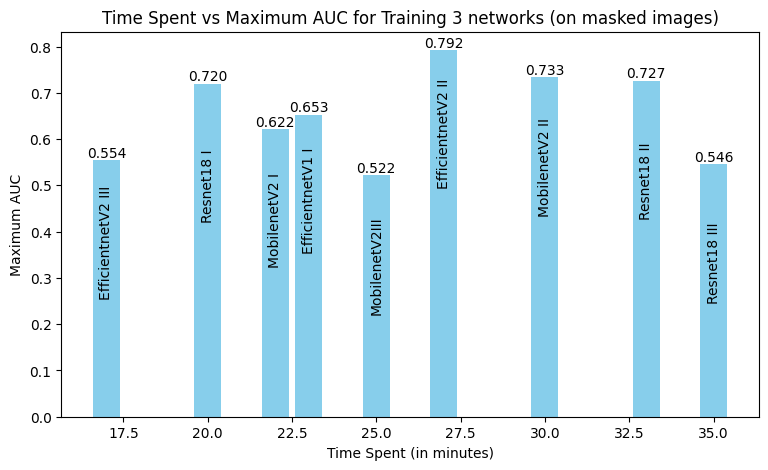

In [ ]:
plt.figure(figsize=(9, 5))
bars = plt.bar(task_times, AUCs, color='skyblue')

for time, auc, task_name in zip(task_times, AUCs, task_names):
    plt.text(time, auc - 0.3, f'{task_name}', ha='center', va='bottom', rotation=90)
    plt.text(time, auc, f'{auc:.3f}', ha='center', va='bottom', rotation=0, color='black')

plt.xlabel('Time Spent (in minutes)')
plt.ylabel('Maximum AUC')
plt.title('Time Spent vs Maximum AUC for Training 3 networks (on masked images)')

plt.show()

For the trainings done on full images instead of masked images, I used the same hyperparameters, thus, no time spent on hyperparameter tuning. So, for this, I could consider adding 1 minute (average time taken for setting up each network training) to the time taken for the training.



In [ ]:
#Pre-trained network 1 : ResNet in 3 settings
T11 = 2
S11 = 0.7746

T12 = 3
S12 = 0.8228

T13 = 4
S13 = 0.6094

#Pre-trained network 2 : MobileNetV2 in 3 settings
T21 = 2
S21 = 0.8087

T22 = 3
S22 = 0.8245

T23 = 5
S23 = 0.6666

#Pre-trained network 3 : EfficientNetB1 in 3 settings
T31 = 3
S31 = 0.7558

T32 = 4
S32 = 0.8053

T33 = 3
S33 = 0.5170

task_times2 = [T11, T12, T13,
         T21, T22, T23,
         T31, T32, T33]

AUCs2 = [S11, S12, S13,
        S21, S22, S23,
        S31, S32, S33]

In [ ]:
plt.figure(figsize=(9, 5))
bars = plt.bar(task_times, AUCs, color='skyblue')

for time, auc, task_name in zip(task_times, AUCs, task_names):
    plt.text(time, auc - 0.3, f'{task_name}', ha='center', va='bottom', rotation=90)
    plt.text(time, auc, f'{auc:.3f}', ha='center', va='bottom', rotation=0, color='black')

plt.xlabel('Time Spent (in minutes)')
plt.ylabel('Maximum AUC')
plt.title('Time Spent vs Maximum AUC for Training 3 networks (on masked images)')

plt.show()

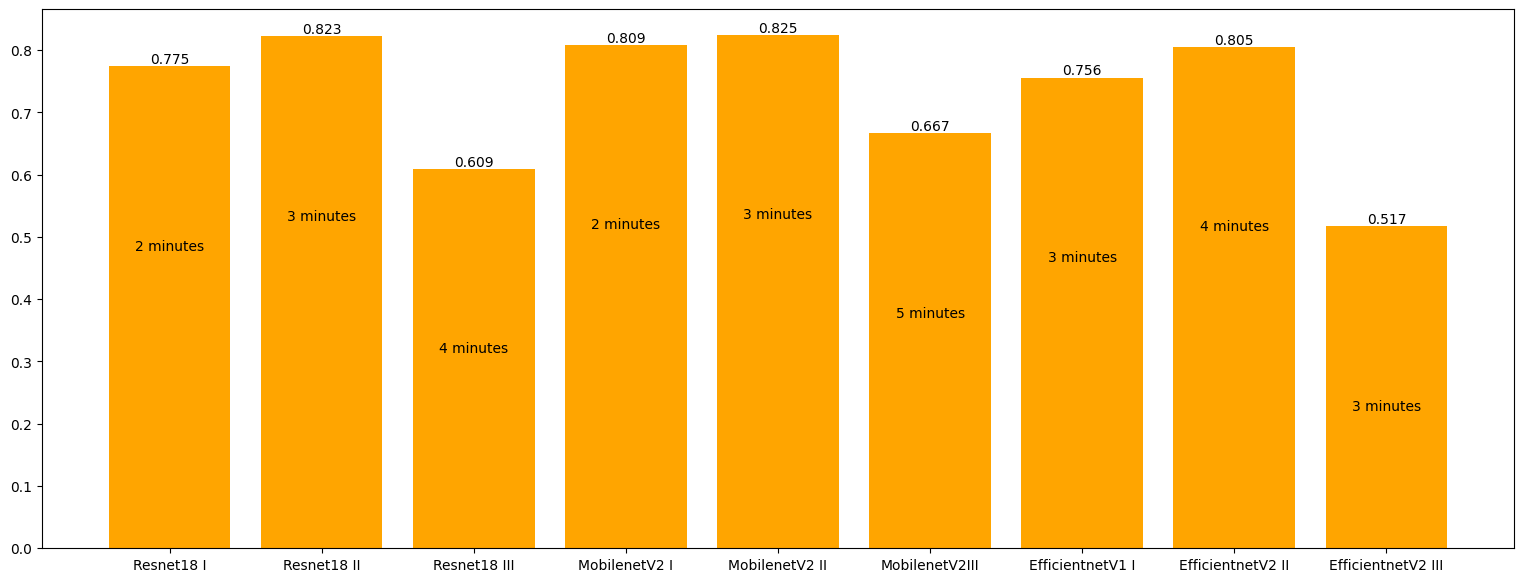

In [213]:
plt.figure(figsize = (19, 7))
bars = plt.bar(task_names, AUCs2, color='orange')

for time, auc, task_name in zip(task_times2, AUCs2, task_names):
    plt.text(task_name, auc - 0.3, f'{time} minutes', ha='center', va='bottom', rotation=0)
    plt.text(task_name, auc, f'{auc:.3f}', ha='center', va='bottom', rotation=0, color='black')

plt.show()


I would also add another factor that took a considerable amount of time. It included all other miscellaneous things like modifying the code to include a scheduler, encountering GPU out-of-memory errors (which requires resetting the session time and re-running the previous blocks of code), choosing among the abundance of pre-trained architectures available, fixing silly errors (for instance: a typo that resulted in two times training with masked images for each network, instead of once with masked image, and once with full image), answering the questions in this notebook, etc. Thus, all this took about 3 hours in total.

In [217]:
misc = 180
total_time = sum(task_times) + sum(task_times2) + misc

print(f"Total time spent on this notebook is approximately {total_time/60} hours")

Total time spent on this notebook is approximately 7.35 hours


As a final note, I performed the above trainings using the Augmented Dataset class as well, but the Test AUCs achieved by all the models in all the settings were lower than when the non-augmented dataset was used. This suggests that the employed data augmentation techniques were not very relevant for this dataset. In general, it is difficult to choose pertinent data augmentation techniques in the case of medical images.